In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import requests 

In [2]:
import pandas_datareader as pdr
import matplotlib.pyplot as plt
#Trade USD/JPY 
fx_data = pdr.get_data_yahoo('JPY=X', '2-March-19') 
fx_data.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-07-08,107.391998,107.102997,107.264999,107.282997,0.0,107.282997
2020-07-09,107.262001,106.665001,107.233002,107.236000,0.0,107.236000
2020-07-12,107.310997,106.788002,106.912003,106.910004,0.0,106.910004
2020-07-13,107.412003,107.120003,107.290001,107.276001,0.0,107.276001
2020-07-15,107.296997,107.150002,107.245003,107.209999,0.0,107.209999


In [5]:
#Moving average crossover strategy
fx_data['9_SMA'] = fx_data['Close'].rolling(window=9).mean()
fx_data['20_SMA'] = fx_data['Close'].rolling(window=50).mean()

fx_data = fx_data[fx_data['20_SMA'].notna()]

# MA trade Signal
Trade_Entry=[]
Trade_Exit=[]
for i in range(len(fx_data)-1):
    if ((fx_data['9_SMA'].values[i] < fx_data['20_SMA'].values[i]) & (fx_data['9_SMA'].values[i+1] > fx_data['20_SMA'].values[i+1])):
        print("Trade Signal for {row} is Entry.".format(row=fx_data.index[i].date()))
        Trade_Entry.append(i)
    elif ((fx_data['9_SMA'].values[i] > fx_data['20_SMA'].values[i]) & (fx_data['9_SMA'].values[i+1] < fx_data['20_SMA'].values[i+1])):
        print("Trade Signal for {row} is Exit.".format(row=fx_data.index[i].date()))
        Trade_Exit.append(i)

Trade Signal for 2020-01-03 is Exit.
Trade Signal for 2020-01-15 is Entry.
Trade Signal for 2020-01-31 is Exit.
Trade Signal for 2020-02-10 is Entry.
Trade Signal for 2020-03-04 is Exit.
Trade Signal for 2020-03-25 is Entry.
Trade Signal for 2020-04-02 is Exit.
Trade Signal for 2020-06-01 is Entry.
Trade Signal for 2020-06-17 is Exit.
Trade Signal for 2020-07-05 is Entry.
Trade Signal for 2020-07-09 is Exit.


C:\Users\Kevin\Anaconda3.04.19.2020\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


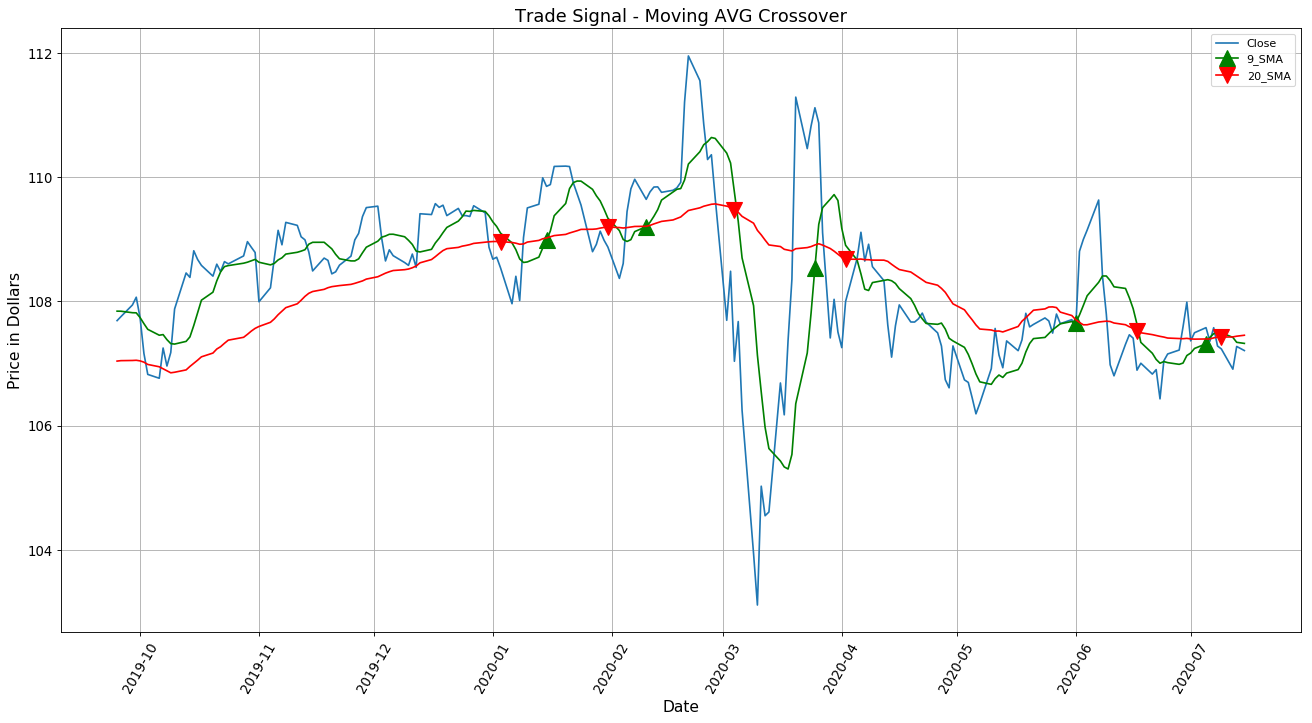

In [7]:
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(fx_data.index, fx_data['Close'])
plt.plot(fx_data.index, fx_data['9_SMA'],'-^', markevery=Trade_Entry, ms=15, color='green')
plt.plot(fx_data.index, fx_data['20_SMA'],'-v', markevery=Trade_Exit, ms=15, color='red')
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Signal - Moving AVG Crossover', fontsize = 16)
plt.legend(['Close','9_SMA','20_SMA'])
plt.grid()
plt.show()

In [8]:
#NEWS TRADING STRATEGY 
# News API
url = 'https://newsapi.org/v2/everything?'

# Parameters
parameters = {
    'q': 'USD/JPY', 
    'sortBy': 'popularity', 
    'pageSize': 100,  
    'apiKey': '41f82539f4ec4ba79932a9ce234f115a', 
}

# API request
response = requests.get(url, params=parameters)

# Convert the response to JSON format and store it in dataframe
data = pd.DataFrame(response.json())

news_df = pd.concat([data['articles'].apply(pd.Series)], axis=1)

fx_news = news_df.loc[:,['publishedAt','title']]
fx_news['publishedAt'] = pd.to_datetime(fx_news['publishedAt'])
fx_news.sort_values(by='publishedAt',inplace=True)

# Business day dates
from pandas.tseries.offsets import BDay
# to get the business day for which particular news headline should be used to make trade calls
def get_trade_open(date):
    curr_date_open = pd.to_datetime(date).floor('d').replace(hour=13,minute=30) - BDay(0)
    curr_date_close = pd.to_datetime(date).floor('d').replace(hour=20,minute=0) - BDay(0)
    
    prev_date_close = (curr_date_open - BDay()).replace(hour=20,minute=0)
    next_date_open = (curr_date_close + BDay()).replace(hour=13,minute=30)
    
    if ((pd.to_datetime(date)>=prev_date_close) & (pd.to_datetime(date)<curr_date_open)):
        return curr_date_open
    elif ((pd.to_datetime(date)>=curr_date_close) & (pd.to_datetime(date)<next_date_open)):
        return next_date_open
    else:
        return None
      
 # Trading time for news headlines
fx_news["trading_time"] = fx_news["publishedAt"].apply(get_trade_open)

fx_news = fx_news[pd.notnull(fx_news['trading_time'])]
fx_news['Date'] = pd.to_datetime(pd.to_datetime(fx_news['trading_time']).dt.date)

In [9]:
#NLTK Imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [10]:
cs = []
for row in range(len(fx_news)):
    cs.append(analyzer.polarity_scores(fx_news['title'].iloc[row])['compound'])

fx_news['compound_vader_score'] = cs
fx_news = fx_news[(fx_news[['compound_vader_score']] != 0).all(axis=1)].reset_index(drop=True)

fx_news.tail()

,publishedAt,title,trading_time,Date,compound_vader_score
8,2020-07-06 04:03:46+00:00,"Asian markets surge, with positive economic da...",2020-07-06 13:30:00+00:00,2020-07-06,0.2023
9,2020-07-09 03:38:05+00:00,Associated Press: Asian markets follow Wall St...,2020-07-09 13:30:00+00:00,2020-07-09,0.5267
10,2020-07-10 03:48:00+00:00,Asian markets fall after Wall Street retreats ...,2020-07-10 13:30:00+00:00,2020-07-10,-0.4215
11,2020-07-13 03:47:00+00:00,Asian markets gain on expectations of upbeat e...,2020-07-13 13:30:00+00:00,2020-07-13,0.5267
12,2020-07-14 03:36:00+00:00,"Asia markets fall amid coronavirus fears, Chin...",2020-07-14 13:30:00+00:00,2020-07-14,-0.4215


In [11]:
unique_dates = fx_news['Date'].unique()
grouped_dates = fx_news.groupby(['Date'])
keys_dates = list(grouped_dates.groups.keys())

max_cs = []
min_cs = []

for key in grouped_dates.groups.keys():
    data = grouped_dates.get_group(key)
    if data["compound_vader_score"].max() > 0:
        max_cs.append(data["compound_vader_score"].max())
    elif data["compound_vader_score"].max() < 0:
        max_cs.append(0)
    
    if data["compound_vader_score"].min() < 0:
        min_cs.append(data["compound_vader_score"].min())
    elif data["compound_vader_score"].min() > 0:
        min_cs.append(0)
    
vader_scores_dict = {'Date':keys_dates,'max_scores':max_cs,'min_scores':min_cs}
vader_scores_df = pd.DataFrame(vader_scores_dict)

In [13]:
final_scores = []
for i in range(len(vader_scores_df)):
    final_scores.append(vader_scores_df['max_scores'].values[i] + vader_scores_df['min_scores'].values[i])

vader_scores_df['final_scores'] = final_scores

vader_scores_df.head()

,Date,max_scores,min_scores,final_scores
0,2020-06-15,0.0000,-0.3818,-0.3818
1,2020-06-16,0.1585,0.0000,0.1585
2,2020-06-22,0.0000,-0.3818,-0.3818
3,2020-06-23,0.2263,0.0000,0.2263
4,2020-06-25,0.4215,0.0000,0.4215


In [16]:
# VADER trade Signal
vader_Entry=[]
vader_Exit=[]
for i in range(len(vader_scores_df)):
    if vader_scores_df['final_scores'].values[i] > 0.20:
        print("Trade Signal for {row} is Entry.".format(row=vader_scores_df['Date'].iloc[i].date()))
        vader_Entry.append(vader_scores_df['Date'].iloc[i].date())
    elif vader_scores_df['final_scores'].values[i] < -0.20:
        print("Trade Call for {row} is Sell.".format(row=vader_scores_df['Date'].iloc[i].date()))
        vader_Exit.append(vader_scores_df['Date'].iloc[i].date())

Trade Call for 2020-06-15 is Sell.
Trade Call for 2020-06-22 is Sell.
Trade Signal for 2020-06-23 is Entry.
Trade Signal for 2020-06-25 is Entry.
Trade Signal for 2020-06-26 is Entry.
Trade Signal for 2020-07-06 is Entry.
Trade Signal for 2020-07-09 is Entry.
Trade Call for 2020-07-10 is Sell.
Trade Signal for 2020-07-13 is Entry.
Trade Call for 2020-07-14 is Sell.


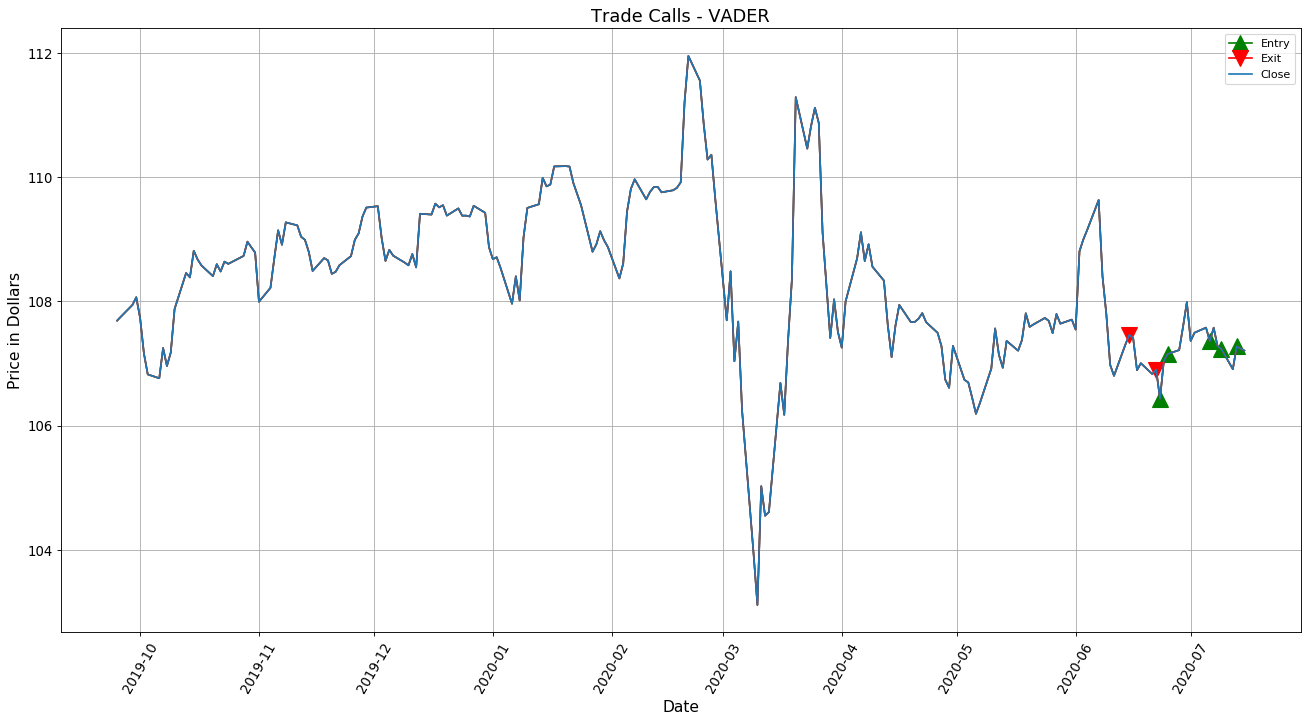

In [17]:
vader_entry = []
for i in range(len(fx_data)):
    if fx_data.index[i].date() in vader_Entry:
        vader_entry.append(i)
        
vader_exit = []
for i in range(len(fx_data)):
    if fx_data.index[i].date() in vader_Exit:
        vader_exit.append(i)
        
plt.figure(figsize=(20, 10),dpi=80)
plt.plot(fx_data.index, fx_data['Close'],'-^', markevery=vader_entry, ms=15, color='green')
plt.plot(fx_data.index, fx_data['Close'],'-v', markevery=vader_exit, ms=15, color='red')
plt.plot(fx_data.index, fx_data['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - VADER', fontsize = 16)
plt.legend(['Entry','Exit','Close'])
plt.grid()
plt.show()

In [ ]:
#SMA signals
final_entry = list(set(Trade_Entry + vader_buy) - set(Trade_Sell)) 
final_exit = list(set(Trade_Sell + vader_sell) - set(Trade_Buy))

plt.figure(figsize=(20, 10),dpi=80)
plt.plot(fx_data.index, fx_data['9_SMA'], color='blue')
plt.plot(fx_data.index, fx_data['20_SMA'], color='orange')
plt.plot(fx_data.index, fx_data['Close'],'-^', markevery=final_buy, ms=15, color='green')
plt.plot(fx_data.index, fx_data['Close'],'-v', markevery=final_sell, ms=15, color='red')
plt.plot(fx_data.index, fx_data['Close'])
plt.xlabel('Date',fontsize=14)
plt.ylabel('Price in Dollars', fontsize = 14)
plt.xticks(rotation='60',fontsize=12)
plt.yticks(fontsize=12)
plt.title('Trade Calls - MERGED', fontsize = 16)
plt.legend(['2_SMA','5_SMA','Buy','Sell','Close'])
plt.grid()
plt.show()